# Preprocessing Steps:

    1. Uncompress files: Gunzip (tii.gz --> .tii)
    2. Field Map/ Distortion Correction: FSL Merge, TOPUP, ApplyTOPUP
    3. Slice Timing Correction: FSL SliceTimer
    4. Motion Correction: SPM Realignment
    5. Coregistration: SPM Coregister

## Import Libraries

(Print out versions for reproducibility. aka Avoid headaches.)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import nibabel as nib
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import nipype
from nipype.interfaces.matlab import MatlabCommand
import nilearn
import pandas as pd
%matplotlib inline

print('Python Version:', sys.version)
print('Nibabel Version', nib.__version__)
print('Matplotlib Version:', matplotlib.__version__)
print('Numpy Version:', np.__version__)
print('Nipype Version:', nipype.__version__)
print('NiLearn Version:', nilearn.__version__)
print('Pandas Version:', pd.__version__)

200512-20:47:01,997 nipype.utils INFO:
	 No new version available.
Python Version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Nibabel Version 3.1.0
Matplotlib Version: 3.0.3
Numpy Version: 1.17.2
Nipype Version: 1.4.2
NiLearn Version: 0.6.2
Pandas Version: 0.25.1


## 1. Gunzip

In [2]:
from nipype.algorithms.misc import Gunzip

In [3]:
base_dir="/Users/isaacmenchaca/Desktop/SNAPP/fMRI/fMRI_data/NIFTI/sub-03"

#### Gunzip on Functional Data

In [4]:
gunzip = Gunzip(in_file=os.path.join(base_dir, 
                                     "Main_task_run1_2x2x2.nii.gz"))
res = gunzip.run()
res.outputs.out_file

'/Users/isaacmenchaca/Desktop/jupyterEx/Main_task_run1_2x2x2.nii'

#### Gunzip on Anatomical Data

In [5]:
gunzip = Gunzip(in_file=os.path.join(base_dir, "t1_mprage.nii.gz"))
res = gunzip.run()
res.outputs.out_file

'/Users/isaacmenchaca/Desktop/jupyterEx/t1_mprage.nii'

#### Gunzip on Field Maps

In [6]:
gunzip = Gunzip(in_file=os.path.join(base_dir, 
                                     "SE_EPI_task_2mm_AP.nii.gz"))
res = gunzip.run()
res.outputs.out_file

'/Users/isaacmenchaca/Desktop/jupyterEx/SE_EPI_task_2mm_AP.nii'

In [7]:
gunzip = Gunzip(in_file=os.path.join(base_dir, 
                                     "SE_EPI_task_2mm_PA.nii.gz"))
res = gunzip.run()
res.outputs.out_file

'/Users/isaacmenchaca/Desktop/jupyterEx/SE_EPI_task_2mm_PA.nii'

## 2. Distortion Correction: FSL Merge, TOPUP, ApplyTOPUP

In [8]:
from nipype.interfaces.fsl import Merge
merger = Merge()
merger.inputs.in_files = ['SE_EPI_task_2mm_AP.nii', 
                          'SE_EPI_task_2mm_PA.nii']
merger.inputs.dimension = 't'
merger.inputs.output_type = 'NIFTI'
merger.run()
merger.cmdline

'fslmerge -t SE_EPI_task_2mm_AP_merged.nii SE_EPI_task_2mm_AP.nii SE_EPI_task_2mm_PA.nii'

In [9]:
from nipype.interfaces.fsl import TOPUP
topup = TOPUP()
topup.inputs.in_file = "SE_EPI_task_2mm_AP_merged.nii" # --imain
topup.inputs.encoding_file = "my_acq_param.txt" # --datain
topup.inputs.output_type = "NIFTI"
topup.run()
topup.cmdline

'topup --config=b02b0.cnf --datain=my_acq_param.txt --imain=SE_EPI_task_2mm_AP_merged.nii --out=SE_EPI_task_2mm_AP_merged_base --iout=SE_EPI_task_2mm_AP_merged_corrected.nii --fout=SE_EPI_task_2mm_AP_merged_field.nii --jacout=jac --logout=SE_EPI_task_2mm_AP_merged_topup.log --rbmout=xfm --dfout=warpfield'

In [10]:
from nipype.interfaces.fsl import ApplyTOPUP
applytopup = ApplyTOPUP()
applytopup.inputs.in_files = "Main_task_run1_2x2x2.nii"
applytopup.inputs.encoding_file = "my_acq_param.txt"
applytopup.inputs.in_topup_fieldcoef = "SE_EPI_task_2mm_AP_merged_base_fieldcoef.nii"
applytopup.inputs.output_type = "NIFTI"
applytopup.inputs.in_topup_movpar = "SE_EPI_task_2mm_AP_merged_base_movpar.txt"
applytopup.inputs.method = "jac"
applytopup.run()
applytopup.cmdline

'applytopup --datain=my_acq_param.txt --imain=Main_task_run1_2x2x2.nii --inindex=1 --topup=SE_EPI_task_2mm_AP_merged_base --method=jac --out=Main_task_run1_2x2x2_corrected.nii'

## 3. Slice Timing Correction: FSL SliceTimer

In [11]:
from nipype.interfaces.fsl import SliceTimer
st = SliceTimer()
st.inputs.in_file = "Main_task_run1_2x2x2_corrected.nii"
st.inputs.custom_timings = "sliceTimings.txt"
st.inputs.out_file = "aMain_task_run1_2x2x2_corrected.nii"
st.inputs.output_type = "NIFTI"
st.run()
st.cmdline

'slicetimer --in=Main_task_run1_2x2x2_corrected.nii --tcustom=sliceTimings.txt --out=aMain_task_run1_2x2x2_corrected.nii'

## 4. Motion Correction: SPM Realignment

In [12]:
from nipype.interfaces.spm import Realign
realign = Realign()
realign.inputs.in_files = 'aMain_task_run1_2x2x2_corrected.nii'
#Estimation options
realign.inputs.fwhm = 5 # smoothing
realign.inputs.interp = 2 # 2nd degree b-spline
realign.inputs.separation = 4
realign.inputs.quality = 0.9
realign.inputs.register_to_mean = True
realign.inputs.wrap = [0, 0, 0]
#Reslice options
realign.inputs.write_interp = 4 # 4th degree b-spline
realign.inputs.write_mask = True
realign.inputs.write_wrap = [0, 0, 0]
realign.run()

#### Obtain resulting Translation and Rotation Data from rp_{Name of functional data file}.txt. Reshape data to appropriate structure to plot.

In [13]:
with open('rp_aMain_task_run1_2x2x2_corrected.txt', 'r') as f:
    x = f.readlines()
    rp_length = len(x)
    data = []
    for line in x:
        temp = line
        split = temp.split('\n')[0].split(' ')
        for splitItem in split:
            if splitItem != '':
                splitItem
                data.append(float(splitItem))
        
    
data_np = np.array([data])
realignment_data = data_np.reshape([rp_length, 6])

#### Plot Translation and Rotation Data

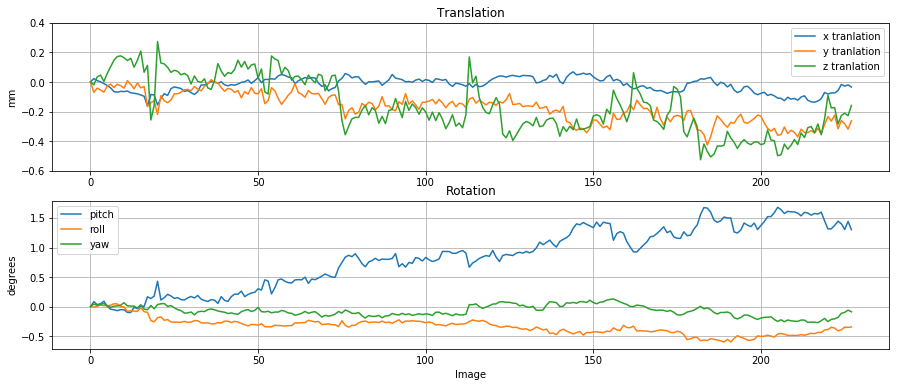

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(realignment_data[:,0])
plt.plot(realignment_data[:,1])
plt.plot(realignment_data[:,2])
plt.ylim([-0.6, 0.4])
plt.grid()
plt.title('Translation')
plt.ylabel('mm')
plt.legend(['x tranlation', 'y tranlation', 'z tranlation'])

plt.subplot(2,1,2)
plt.plot(np.rad2deg(realignment_data[:,3]))
plt.plot(np.rad2deg(realignment_data[:,4]))
plt.plot(np.rad2deg(realignment_data[:,5]))
plt.grid()
plt.title('Rotation')
plt.xlabel('Image')
plt.ylabel('degrees')
plt.legend(['pitch', 'roll', 'yaw'])
plt.show()

## 5. Coregistration: SPM Coregister

In [15]:
from nipype.interfaces.spm import Coregister
coreg = Coregister()
coreg.inputs.target = 'meanaMain_task_run1_2x2x2_corrected.nii'
coreg.inputs.source = 't1_mprage.nii'
coreg.inputs.cost_function = 'nmi'
coreg.inputs.write_interp = 4
coreg.inputs.write_mask = False
coreg.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 
                          0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]
coreg.inputs.separation = [4, 2]
coreg.inputs.write_wrap = [0, 0, 0]
coreg.inputs.fwhm = [7, 7]
coreg.run()

#### Check coregistration results

In [16]:
t1_mprage = nib.load('t1_mprage.nii')
rt1_mprage = nib.load('rt1_mprage.nii')
meanrun1 = nib.load('meanaMain_task_run1_2x2x2_corrected.nii')

print('Comparing data shapes:')
print('t1_mprage:', t1_mprage.shape)
print('rt1_mprage:', rt1_mprage.shape)
print('meanMain_task_run1:', meanrun1.shape)

Comparing data shapes:
t1_mprage: (208, 300, 320)
rt1_mprage: (110, 106, 60)
meanMain_task_run1: (110, 106, 60)


Check Coregistration Results: Below are plots to view correlations within x, y, and z coordinates for meanMain_task_run1 and rt1_mprage. Change coordinates to verify that they do indeed match. rt1_mprage (previously t1_mprage) has been resized as a result of the coregistration.

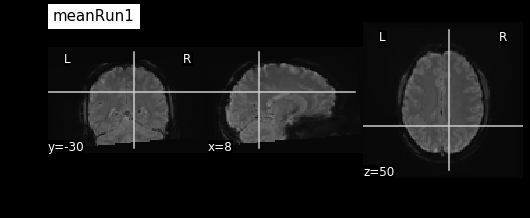

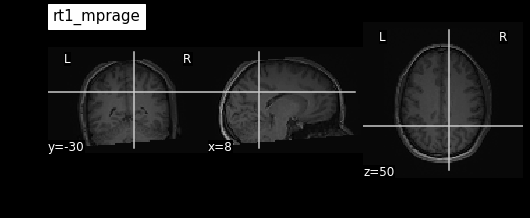

In [17]:
from nilearn.plotting import plot_anat

x_coord, y_coord, z_coord = 8, -30, 50
plot_anat(meanrun1, cut_coords=(x_coord, y_coord, z_coord), 
          title='meanRun1')
plot_anat(rt1_mprage, cut_coords=(x_coord, y_coord, z_coord), 
          title='rt1_mprage')
plt.show()

** We can continue to do this for all subjects and runs, or we can automate the tasks by creating a workflow and connecting steps as nodes. **

# Automation

## Build a workflow for preprocessing pipeline

In [18]:
from nipype import Node, Workflow
output_dir = "/Users/isaacmenchaca/Desktop/jupyterEx"
preproc_pipeline = Workflow(name='preproc_pipeline', 
                            base_dir=os.path.join(output_dir, 'output/'))

## 1. Gunzip

In [19]:
gunzip_func = Node(Gunzip(), 
                   name = 'gunzip_func')

gunzip_fmapAP = Node(Gunzip(), 
                     name = 'gunzip_fmapAP')

gunzip_fmapPA = Node(Gunzip(), 
                     name = 'gunzip_fmapPA')

gunzip_anat = Node(Gunzip(), 
                   name = 'gunzip_anat')

## 1.5. Concatenate Files - Combine Fmaps into a list

(You can make your own steps, in this case I had to make one to allow more than one input into a next step)

In [20]:
from nipype.interfaces.utility import Function

def concatenate_files(file1, file2):
    files_list = []
    files_list.append(file1)
    files_list.append(file2)
    print(files_list)
    return files_list

concatenate = Node(Function(input_names=["file1", "file2"], 
                            output_names=["all_files"], 
                            function=concatenate_files), 
                   name="concatenate_files")

In [21]:
preproc_pipeline.connect([(gunzip_fmapAP,concatenate, [('out_file', 'file1')]),
                          (gunzip_fmapPA,concatenate, [('out_file', 'file2')])])

## 2. Distortion Correction: FSL Merge, TOPUP, ApplyTOPUP

In [22]:
fslmerge = Node(Merge(dimension='t',
                   output_type='NIFTI'), name='FSLmerge')

topup = Node(TOPUP(encoding_file=os.path.join(output_dir,'my_acq_param.txt'), 
                  output_type='NIFTI'), name='topup')

applyTOPUP = Node(ApplyTOPUP(encoding_file=os.path.join(output_dir,'my_acq_param.txt'), 
                  output_type='NIFTI', method='jac'), name='applyTOPUP')

preproc_pipeline.connect([(concatenate, fslmerge, 
                           [('all_files', 'in_files')])])
preproc_pipeline.connect([(fslmerge, topup, 
                           [('merged_file', 'in_file')])])
preproc_pipeline.connect([(gunzip_func, applyTOPUP, 
                           [('out_file', 'in_files')]),
                         (topup, applyTOPUP, 
                          [('out_fieldcoef', 'in_topup_fieldcoef'),
                           ('out_movpar', 'in_topup_movpar')])])

## 3. Slice Timing Correction: FSL SliceTimer

In [23]:
sliceTimer = Node(SliceTimer(custom_timings = "sliceTimings.txt",
                   output_type='NIFTI'), name='sliceTimer')

preproc_pipeline.connect([(applyTOPUP, sliceTimer,
                           [('out_corrected', 'in_file')])])

## 4. Motion Correction: SPM Realignment

In [24]:
realign = Node(Realign(fwhm=5, interp=2, separation=4,
                      quality=0.9, register_to_mean=True,
                      wrap=[0,0,0], write_interp=4,
                      write_mask=True, write_wrap=[0,0,0]), name='realign')

In [25]:
preproc_pipeline.connect([(sliceTimer, realign, 
                           [('slice_time_corrected_file', 'in_files')])])

## 5. Coregistration: SPM Coregister

In [26]:
coreg = Node(Coregister(cost_function = 'nmi', write_interp = 4,
                       write_mask = False, tolerance = [0.02, 0.02, 0.02, 0.001, 
                                                        0.001, 0.001, 0.01, 0.01,
                                                        0.01, 0.001, 0.001, 0.001],
                        separation = [4, 2], write_wrap = [0, 0, 0],
                        fwhm = [7, 7]), name='coregistration')

preproc_pipeline.connect([(realign, coreg, [('mean_image', 'target')]),
                         (gunzip_anat, coreg, [('out_file', 'source')])])

## View steps

200512-21:06:39,543 nipype.workflow INFO:
	 Generated workflow graph: /Users/isaacmenchaca/Desktop/jupyterEx/output/preproc_pipeline/graph.png (graph2use=orig, simple_form=True).


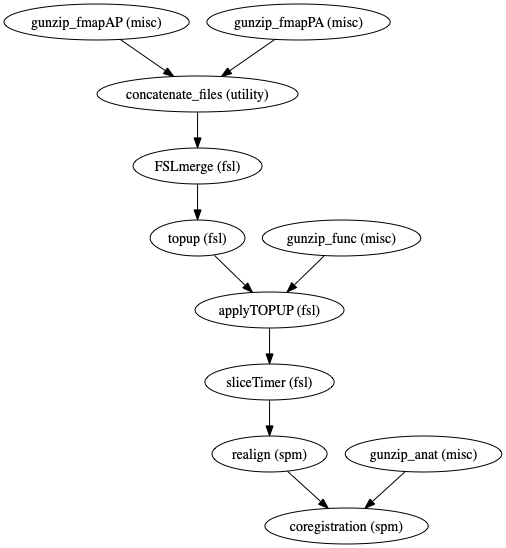

In [28]:
from IPython.display import Image
preproc_pipeline.write_graph(graph2use='orig')
Image(filename='output/preproc_pipeline/graph.png')

## View steps with inputs and outputs

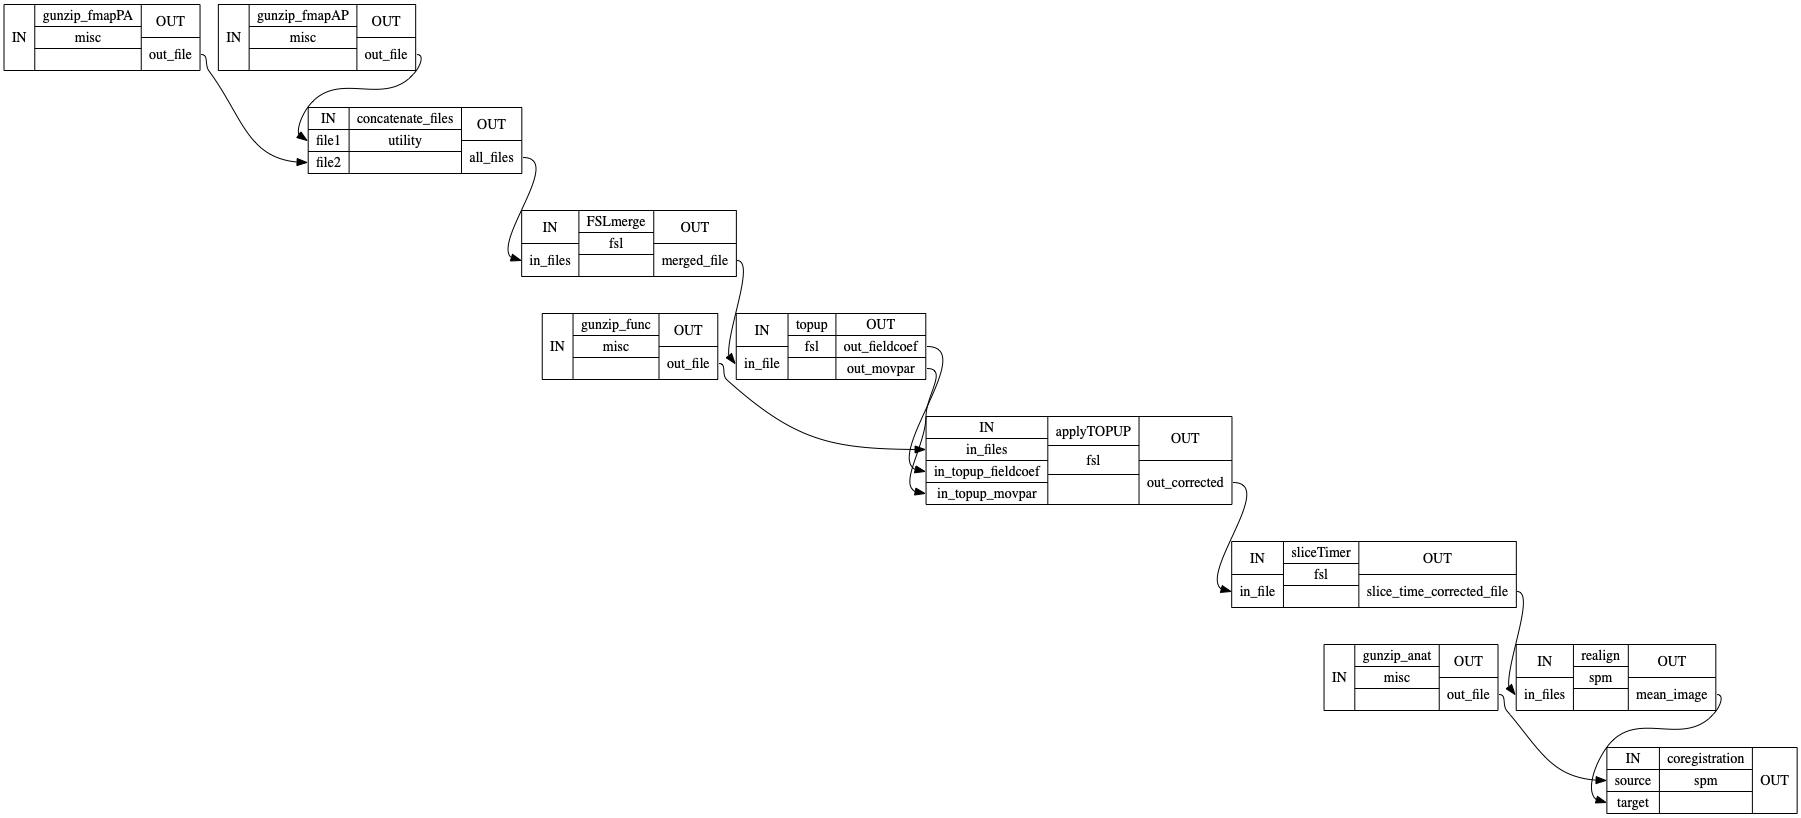

In [29]:
Image(filename='output/preproc_pipeline/graph_detailed.png')

## Run Pipeline

In [30]:
# Input initial files
gunzip_func.inputs.in_file = os.path.join(base_dir, 
                                          "Main_task_run1_2x2x2.nii.gz")
gunzip_fmapAP.inputs.in_file = os.path.join(base_dir, 
                                            "SE_EPI_task_2mm_AP.nii.gz")
gunzip_fmapPA.inputs.in_file = os.path.join(base_dir, 
                                            "SE_EPI_task_2mm_PA.nii.gz")
gunzip_anat.inputs.in_file = os.path.join(base_dir, 
                                          "t1_mprage.nii.gz")
# run pipeline and track time: ~10 min 30 sec
%time preproc_pipeline.run()

200512-22:03:08,919 nipype.workflow INFO:
	 Workflow preproc_pipeline settings: ['check', 'execution', 'logging', 'monitoring']
200512-22:03:08,938 nipype.workflow INFO:
	 Running serially.
200512-22:03:08,939 nipype.workflow INFO:
	 [Node] Setting-up "preproc_pipeline.gunzip_anat" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/preproc_pipeline/gunzip_anat".
200512-22:03:08,946 nipype.workflow INFO:
	 [Node] Running "gunzip_anat" ("nipype.algorithms.misc.Gunzip")
200512-22:03:09,273 nipype.workflow INFO:
	 [Node] Finished "preproc_pipeline.gunzip_anat".
200512-22:03:09,275 nipype.workflow INFO:
	 [Node] Setting-up "preproc_pipeline.gunzip_func" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/preproc_pipeline/gunzip_func".
200512-22:03:09,278 nipype.workflow INFO:
	 [Node] Running "gunzip_func" ("nipype.algorithms.misc.Gunzip")
200512-22:03:12,273 nipype.workflow INFO:
	 [Node] Finished "preproc_pipeline.gunzip_func".
200512-22:03:12,274 nipype.workflow INFO:
	 [Node] Setting-up "p

## Run multiple runs (or subjects) in parallel

Individual run took us ~10 min 30 sec.
What if we want to run the pipeline 5 more times? Will it take over an hour?

First clone the intial preprocessing workflow

In [31]:
# First, let's copy/clone ' preproc_pipeline' 
preproc_pipeline02 = preproc_pipeline.clone('preproc_pipeline02')
preproc_pipeline03 = preproc_pipeline.clone('preproc_pipeline03')
preproc_pipeline04 = preproc_pipeline.clone('preproc_pipeline04')
preproc_pipeline05 = preproc_pipeline.clone('preproc_pipeline05')

Initial Functional Inputs into all workflows.

In [32]:
preproc_pipeline02.inputs.gunzip_func.in_file = os.path.join(base_dir, 
                                          "Main_task_run2_2x2x2.nii.gz")
preproc_pipeline03.inputs.gunzip_func.in_file = os.path.join(base_dir, 
                                          "Main_task_run3_2x2x2.nii.gz")
preproc_pipeline04.inputs.gunzip_func.in_file = os.path.join(base_dir, 
                                          "Main_task_run4_2x2x2.nii.gz")
preproc_pipeline05.inputs.gunzip_func.in_file = os.path.join(base_dir, 
                                          "Main_task_run5_2x2x2.nii.gz")

Make another workflow to run them all in parallel.

In [33]:
parallel_workflow = Workflow(name='parallel_workflow', 
                            base_dir=os.path.join(output_dir, 'output/'))

In [34]:
parallel_workflow.add_nodes([preproc_pipeline, preproc_pipeline02, 
                             preproc_pipeline03, preproc_pipeline04, 
                             preproc_pipeline05])

200512-22:22:41,525 nipype.workflow INFO:
	 Generated workflow graph: /Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/graph.png (graph2use=flat, simple_form=True).


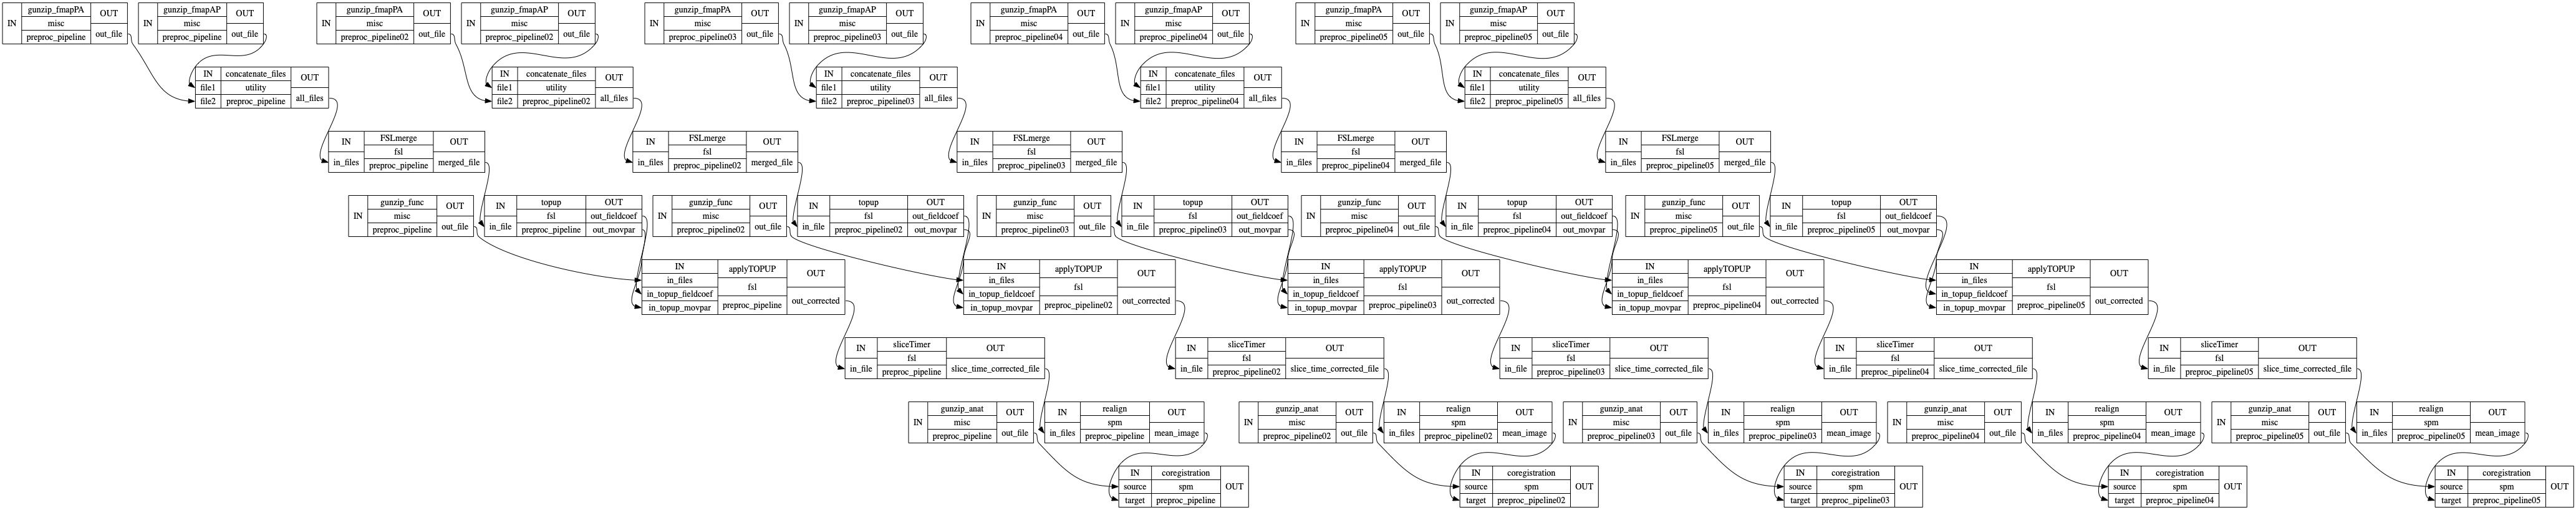

In [35]:
parallel_workflow.write_graph(graph2use='flat')
Image(filename='output/parallel_workflow/graph_detailed.png')

In [36]:
%time parallel_workflow.run('MultiProc', plugin_args={'n_procs': 5})

200512-22:39:36,870 nipype.workflow INFO:
	 Workflow parallel_workflow settings: ['check', 'execution', 'logging', 'monitoring']
200512-22:39:36,903 nipype.workflow INFO:
	 Running in parallel.
200512-22:39:36,915 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 20 jobs ready. Free memory (GB): 7.20/7.20, Free processors: 5/5.
200512-22:39:37,26 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline.gunzip_anat" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline/gunzip_anat".
200512-22:39:37,27 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline.gunzip_func" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline/gunzip_func".
200512-22:39:37,27 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline.gunzip_fmapPA" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline/gunzip_fmapPA".
200512-22:39:37,28 nipype.workfl

200512-22:39:42,922 nipype.workflow INFO:
	 [Job 5] Completed (parallel_workflow.preproc_pipeline.FSLmerge).
200512-22:39:42,924 nipype.workflow INFO:
	 [Job 15] Completed (parallel_workflow.preproc_pipeline02.concatenate_files).
200512-22:39:42,925 nipype.workflow INFO:
	 [Job 22] Completed (parallel_workflow.preproc_pipeline03.gunzip_anat).
200512-22:39:42,928 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 12 jobs ready. Free memory (GB): 7.00/7.20, Free processors: 4/5.
                     Currently running:
                       * parallel_workflow.preproc_pipeline03.gunzip_func
200512-22:39:42,987 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline02.FSLmerge" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline02/FSLmerge".
200512-22:39:42,987 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline.topup" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline/

200512-22:39:48,932 nipype.workflow INFO:
	 [Job 35] Completed (parallel_workflow.preproc_pipeline04.gunzip_fmapPA).
200512-22:39:48,935 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 6.80/7.20, Free processors: 3/5.
                     Currently running:
                       * parallel_workflow.preproc_pipeline02.topup
                       * parallel_workflow.preproc_pipeline.topup
200512-22:39:48,989 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline03.topup" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline03/topup".
200512-22:39:48,990 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline04.gunzip_fmapAP" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline04/gunzip_fmapAP".
200512-22:39:48,991 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline05.gunzip_anat" in "/Users/isaacmenchaca/Desktop/j

200512-22:39:59,8 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline05.concatenate_files" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline05/concatenate_files".
200512-22:39:59,16 nipype.workflow INFO:
	 [Node] Running "concatenate_files" ("nipype.interfaces.utility.wrappers.Function")
['/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline05/gunzip_fmapAP/SE_EPI_task_2mm_AP.nii', '/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline05/gunzip_fmapPA/SE_EPI_task_2mm_PA.nii']
200512-22:39:59,26 nipype.workflow INFO:
	 [Node] Finished "parallel_workflow.preproc_pipeline05.concatenate_files".
200512-22:40:00,947 nipype.workflow INFO:
	 [Job 48] Completed (parallel_workflow.preproc_pipeline05.concatenate_files).
200512-22:40:00,950 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 1 jobs ready. Free memory (GB): 6.40/7.20, Free processors: 1/5.
                     Cu

200512-22:49:35,810 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline03.applyTOPUP" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline03/applyTOPUP".
200512-22:49:35,822 nipype.workflow INFO:
	 [Node] Running "applyTOPUP" ("nipype.interfaces.fsl.epi.ApplyTOPUP"), a CommandLine Interface with command:
applytopup --datain=/Users/isaacmenchaca/Desktop/jupyterEx/my_acq_param.txt --imain=/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline03/gunzip_func/Main_task_run3_2x2x2.nii --inindex=1 --topup=/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline03/applyTOPUP/SE_EPI_task_2mm_AP_merged_base --method=jac --out=Main_task_run3_2x2x2_corrected.nii
200512-22:49:37,740 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 0 jobs ready. Free memory (GB): 6.20/7.20, Free processors: 0/5.
                     Currently running:
                       * parallel_workflow.preproc_

200512-22:52:14,64 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 1 jobs ready. Free memory (GB): 6.40/7.20, Free processors: 1/5.
                     Currently running:
                       * parallel_workflow.preproc_pipeline02.sliceTimer
                       * parallel_workflow.preproc_pipeline.sliceTimer
                       * parallel_workflow.preproc_pipeline05.applyTOPUP
                       * parallel_workflow.preproc_pipeline04.applyTOPUP
200512-22:52:14,271 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline03.sliceTimer" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline03/sliceTimer".
200512-22:52:14,309 nipype.workflow INFO:
	 [Node] Running "sliceTimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline03/applyTOPUP/Main_task_run3_2x2x2_corrected.nii --tcustom=sli

200512-22:53:26,119 nipype.workflow INFO:
	 [Node] Setting-up "parallel_workflow.preproc_pipeline03.realign" in "/Users/isaacmenchaca/Desktop/jupyterEx/output/parallel_workflow/preproc_pipeline03/realign".
200512-22:53:28,47 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 0 jobs ready. Free memory (GB): 6.20/7.20, Free processors: 0/5.
                     Currently running:
                       * parallel_workflow.preproc_pipeline03.realign
                       * parallel_workflow.preproc_pipeline04.realign
                       * parallel_workflow.preproc_pipeline02.realign
                       * parallel_workflow.preproc_pipeline.realign
                       * parallel_workflow.preproc_pipeline05.sliceTimer
200512-22:53:34,455 nipype.workflow INFO:
	 [Node] Running "realign" ("nipype.interfaces.spm.preprocess.Realign")
200512-22:53:36,701 nipype.workflow INFO:
	 [Node] Finished "parallel_workflow.preproc_pipeline05.sliceTimer".
200512-22:53:37,190 nipype.workflow I

200512-22:57:46,388 nipype.workflow INFO:
	 [Job 32] Completed (parallel_workflow.preproc_pipeline03.coregistration).
200512-22:57:46,392 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 6.80/7.20, Free processors: 3/5.
                     Currently running:
                       * parallel_workflow.preproc_pipeline02.coregistration
                       * parallel_workflow.preproc_pipeline.coregistration
200512-22:57:46,963 nipype.workflow INFO:
	 [Node] Finished "parallel_workflow.preproc_pipeline.coregistration".
200512-22:57:47,442 nipype.workflow INFO:
	 [Node] Finished "parallel_workflow.preproc_pipeline02.coregistration".
200512-22:57:48,392 nipype.workflow INFO:
	 [Job 10] Completed (parallel_workflow.preproc_pipeline.coregistration).
200512-22:57:48,395 nipype.workflow INFO:
	 [Job 21] Completed (parallel_workflow.preproc_pipeline02.coregistration).
200512-22:57:48,399 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs re